# **Visualizing How UMAP Distortion Affects DBSCAN Across Multiple Datasets**

This cell creates three synthetic high-dimensional datasets—simple blobs, a classification dataset with overlapping classes, and an anisotropic Gaussian mixture. Each dataset receives structured “cluster-invading” noise to increase difficulty.
The code then embeds every dataset with three different UMAP configurations that vary only in `min_dist`, ranging from highly contractive (“aggressive”) to more distance-preserving (“conservative”).

DBSCAN runs on each embedding with a fixed `eps` and `min_samples` setting. For every dataset–UMAP combination, the plot reports the number of clusters detected and the ARI score relative to the ground-truth labels. The resulting 3×3 grid highlights how different UMAP compressions alter cluster separability and how DBSCAN responds to these distortions.


/home/desktop/projects/observerbias/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/desktop/projects/observerbias/.venv/lib/python3.13/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/desktop/projects/observerbias/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/desktop/projects/observerbias/.venv/lib/python3.13/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/desktop/projects/observerbias/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use 

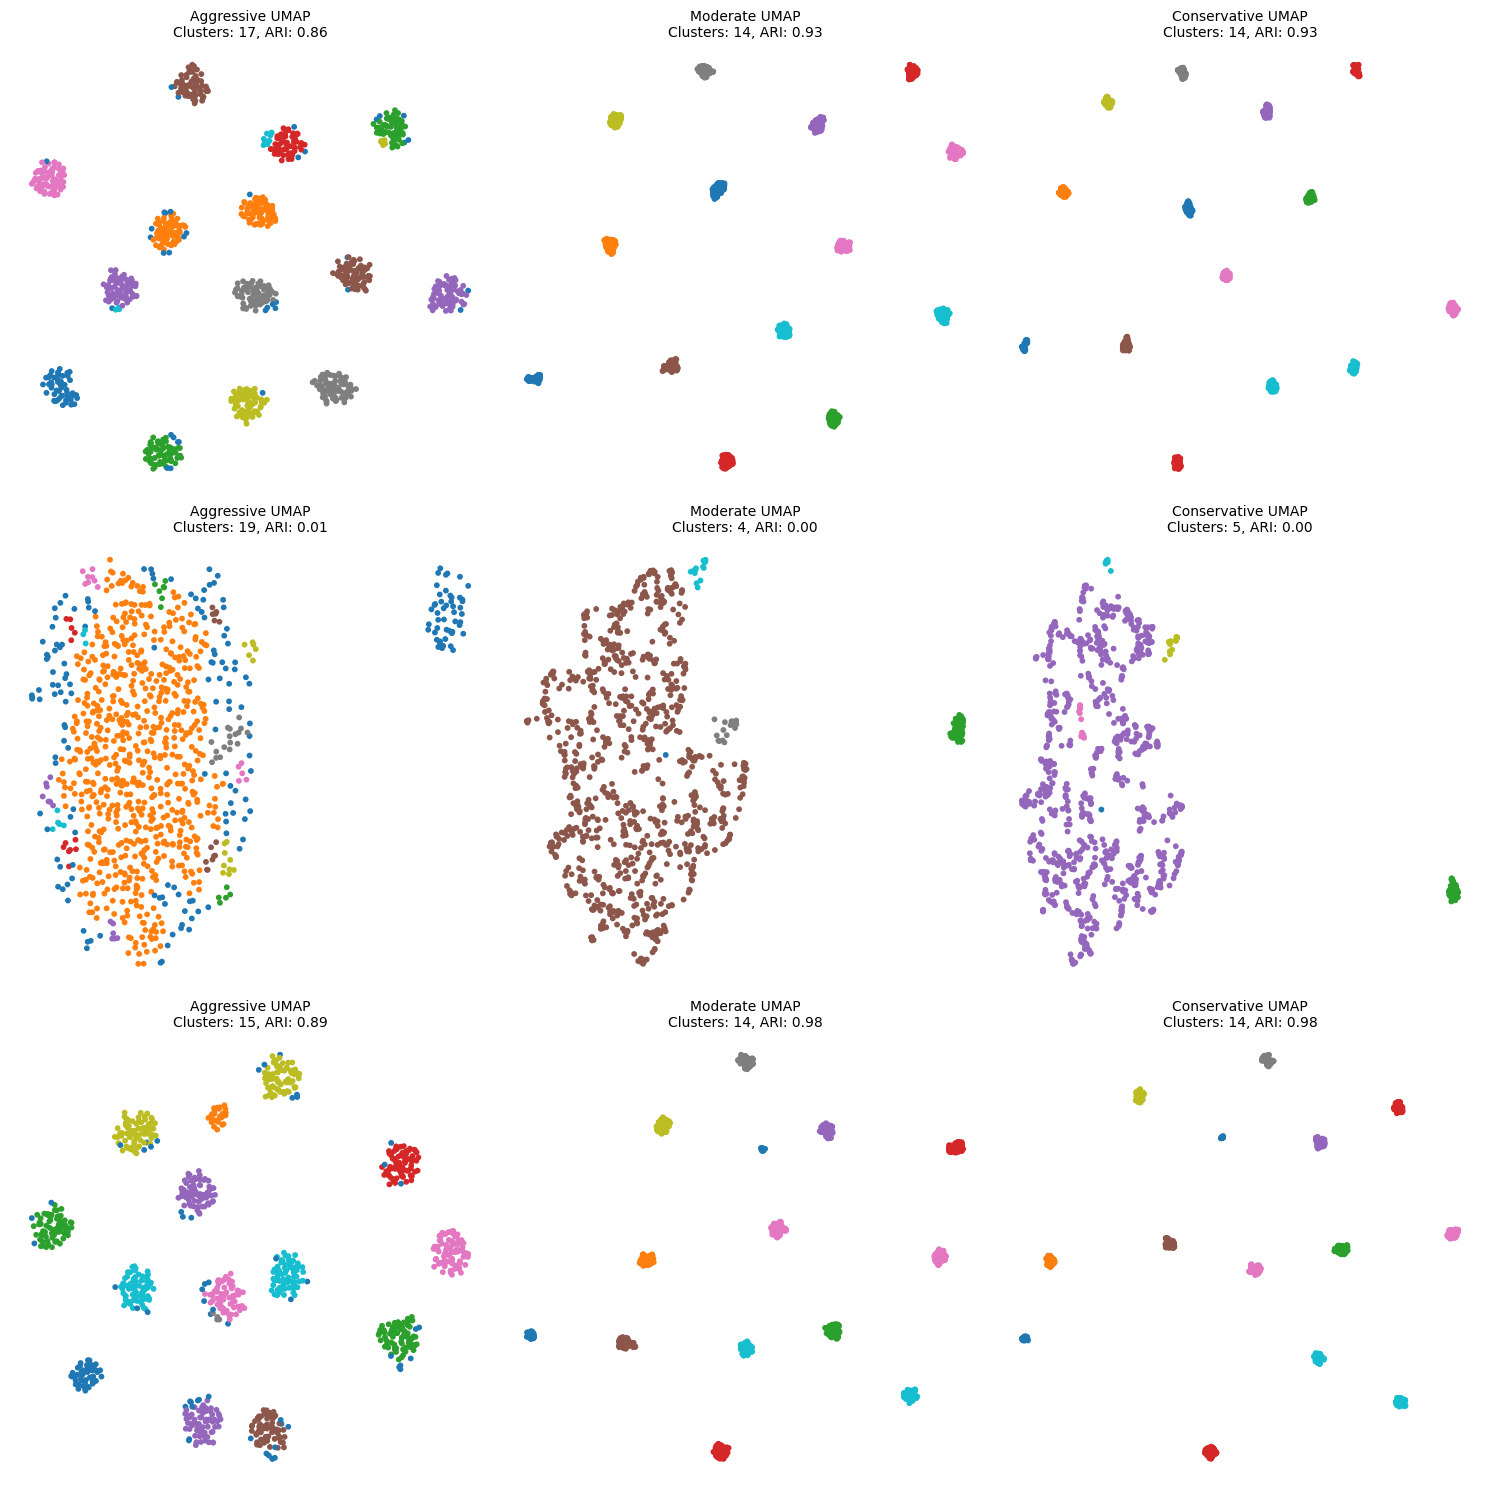

In [1]:
import numpy as np
from sklearn.datasets import make_blobs, make_classification
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score
import umap
import matplotlib.pyplot as plt

# --------------------------
# 1. Generate datasets
# --------------------------

datasets = []

# Dataset 1: simple blobs
X1, y1 = make_blobs(n_samples=1000, n_features=50, centers=13, cluster_std=1.0, random_state=42)
datasets.append(("Blobs", X1, y1))

# Dataset 2: classification with overlapping clusters
X2, y2 = make_classification(
    n_samples=1000,
    n_features=50,
    n_informative=10,
    n_redundant=10,
    n_clusters_per_class=2,
    n_classes=4,
    flip_y=0.1,
    class_sep=1.0,
    random_state=42
)
datasets.append(("Classification", X2, y2))

# Dataset 3: anisotropic Gaussian mixture
n_samples = 1000
n_features = 50
n_clusters = 13
X3_list, y3_list = [], []

for i in range(n_clusters):
    cov = np.diag(np.random.uniform(0.5, 3.0, n_features))  # anisotropic
    mean = np.random.uniform(-10, 10, n_features)
    X_i = np.random.multivariate_normal(mean, cov, size=n_samples//n_clusters)
    y_i = np.full(n_samples//n_clusters, i)
    X3_list.append(X_i)
    y3_list.append(y_i)

X3 = np.vstack(X3_list)
y3 = np.hstack(y3_list)
datasets.append(("Anisotropic", X3, y3))

# --------------------------
# 2. Add structured noise to all datasets
# --------------------------
for idx, (name, X, y) in enumerate(datasets):
    X_noisy = X.copy()
    # Strong cluster invasion for first 50 points
    X_noisy[:50] += np.random.normal(loc=20, scale=10, size=(50, X.shape[1]))
    datasets[idx] = (name, X_noisy, y)

# --------------------------
# 3. UMAP configurations
# --------------------------
umap_configs = [
    {"n_neighbors": 5, "min_dist": 0.9, "title": "Aggressive UMAP"},
    {"n_neighbors": 5, "min_dist": 0.1, "title": "Moderate UMAP"},
    {"n_neighbors": 5, "min_dist": 0.0, "title": "Conservative UMAP"},
]

# --------------------------
# 4. Plot 3x3 grid (row = dataset, col = UMAP)
# --------------------------
fig, axes = plt.subplots(len(datasets), len(umap_configs), figsize=(15, 15), dpi=100)  # 1500x1500 pixels
eps = 0.5
min_samples = 5

for row_idx, (dataset_name, X, y_true) in enumerate(datasets):
    for col_idx, cfg in enumerate(umap_configs):
        reducer = umap.UMAP(n_neighbors=cfg["n_neighbors"], min_dist=cfg["min_dist"], random_state=42)
        X_emb = reducer.fit_transform(X)

        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X_emb)
        labels = clustering.labels_

        n_detected = len(set(labels)) - (1 if -1 in labels else 0)
        ari = adjusted_rand_score(y_true, labels)

        ax = axes[row_idx, col_idx]
        ax.scatter(X_emb[:, 0], X_emb[:, 1], c=labels, cmap='tab10', s=10)
        ax.set_title(f"{cfg['title']}\nClusters: {n_detected}, ARI: {ari:.2f}", fontsize=10)
        ax.axis('off')

        if col_idx == 0:
            ax.set_ylabel(dataset_name, fontsize=12)

plt.tight_layout()

plt.savefig("ClusterFailures.png")
plt.show()



# **Exploring How UMAP Compression Interacts With Clustering Hyperparameters**

This cell evaluates how sensitive common clustering methods become when their hyperparameters interact with UMAP’s `min_dist` setting. The experiment begins with a high-dimensional anisotropic Gaussian mixture and adds strong cluster-invading noise to increase ambiguity.
For each value of `min_dist`, UMAP produces a different 2D embedding. Three clustering algorithms—DBSCAN, OPTICS, and hierarchical clustering—then run across wide hyperparameter ranges. After each run, the code measures how far the detected number of clusters deviates from the known ground truth.

The results accumulate across all configurations and visualize as a 3D scatter plot. Each point represents a single clustering outcome, positioned by UMAP’s `min_dist`, the algorithm’s hyperparameter, and the absolute cluster count error. This view highlights how easily cluster structure drifts when UMAP reshapes distances and how each algorithm responds under varying levels of compression.


/home/desktop/projects/observerbias/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/desktop/projects/observerbias/.venv/lib/python3.13/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/desktop/projects/observerbias/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/desktop/projects/observerbias/.venv/lib/python3.13/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/desktop/projects/observerbias/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use 

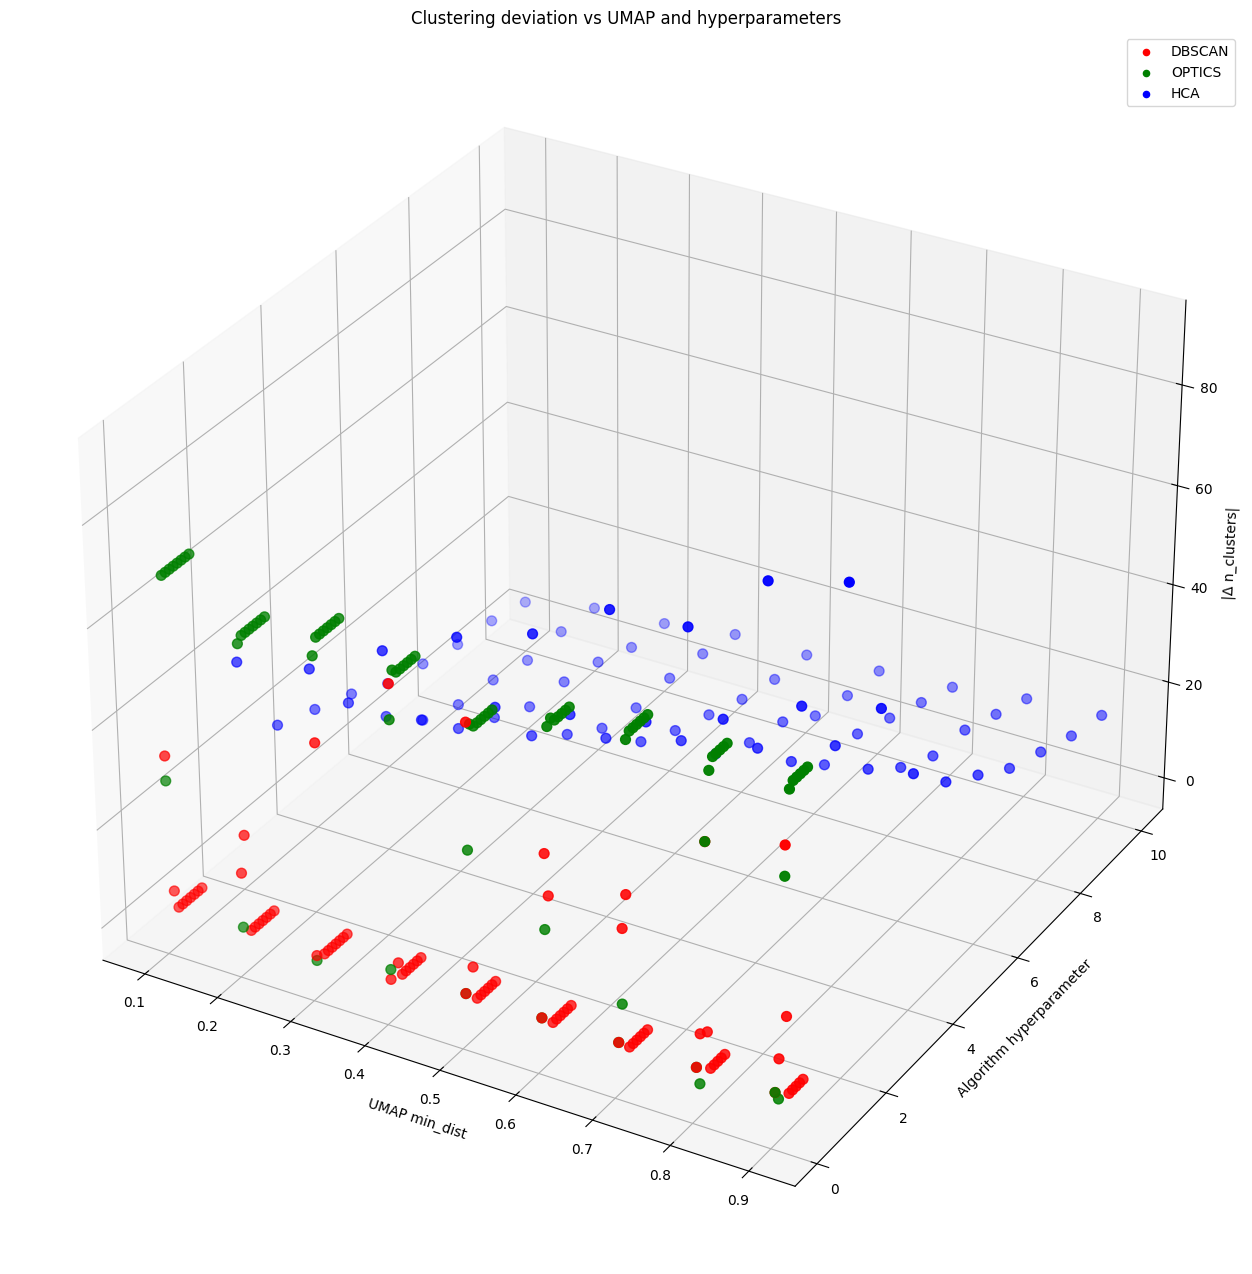

In [2]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN, AgglomerativeClustering, OPTICS
from sklearn.metrics import adjusted_rand_score
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --------------------------
# 1. Create dataset
# --------------------------
n_samples = 1000
n_features = 50
n_clusters = 4

# Anisotropic Gaussian mixture
X_list, y_list = [], []
for i in range(n_clusters):
    cov = np.diag(np.random.uniform(0.5, 3.0, n_features))
    mean = np.random.uniform(-10, 10, n_features)
    X_i = np.random.multivariate_normal(mean, cov, size=n_samples//n_clusters)
    y_i = np.full(n_samples//n_clusters, i)
    X_list.append(X_i)
    y_list.append(y_i)

X = np.vstack(X_list)
y_true = np.hstack(y_list)

# Add strong cluster-invading noise
X[:50] += np.random.normal(loc=20, scale=10, size=(50, X.shape[1]))

# --------------------------
# 2. UMAP embeddings
# --------------------------
umap_settings = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # min_dist as proxy for embedding distance

# --------------------------
# 3. Clustering hyperparameters
# --------------------------
dbscan_eps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
optics_eps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
hca_linkage = [2, 3, 4, 5, 6, 7, 8, 9, 10]  # distance threshold

# Prepare storage for 3D plot
X_plot, Y_plot, Z_plot, C_plot = [], [], [], []

# --------------------------
# 4. Run clustering experiments
# --------------------------
for min_dist in umap_settings:
    reducer = umap.UMAP(n_neighbors=5, min_dist=min_dist, random_state=42)
    X_emb = reducer.fit_transform(X)

    # ---- DBSCAN ----
    for eps in dbscan_eps:
        clustering = DBSCAN(eps=eps, min_samples=5).fit(X_emb)
        n_clusters_detected = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
        delta = abs(n_clusters_detected - n_clusters)

        X_plot.append(min_dist)
        Y_plot.append(eps)
        Z_plot.append(delta)
        C_plot.append("DBSCAN")

    # ---- OPTICS ----
    for eps in optics_eps:
        clustering = OPTICS(max_eps=eps, min_samples=5).fit(X_emb)
        n_clusters_detected = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
        delta = abs(n_clusters_detected - n_clusters)

        X_plot.append(min_dist)
        Y_plot.append(eps)
        Z_plot.append(delta)
        C_plot.append("OPTICS")

    # ---- HCA ----
    for link_thresh in hca_linkage:
        clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=link_thresh, linkage='ward')
        clustering.fit(X_emb)
        n_clusters_detected = len(set(clustering.labels_))
        delta = abs(n_clusters_detected - n_clusters)

        X_plot.append(min_dist)
        Y_plot.append(link_thresh)
        Z_plot.append(delta)
        C_plot.append("HCA")

# --------------------------
# 5. 3D plot
# --------------------------
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='3d')

# map colors to algorithms
color_map = {"DBSCAN": "r", "OPTICS": "g", "HCA": "b"}
colors = [color_map[c] for c in C_plot]

ax.scatter(X_plot, Y_plot, Z_plot, c=colors, s=50)

ax.set_xlabel("UMAP min_dist")
ax.set_ylabel("Algorithm hyperparameter")
ax.set_zlabel("|Δ n_clusters|")
ax.set_title("Clustering deviation vs UMAP and hyperparameters")

# legend
for algo, color in color_map.items():
    ax.scatter([], [], [], c=color, label=algo)
ax.legend()
plt.savefig("ClusterFailures_3Dplot.png")
plt.show()




# **Summarizing Cluster Deviation and Comparing Algorithm Stability**

This cell compiles all experiment results into a single DataFrame to analyze how strongly each clustering method deviates from the true number of clusters. The table calculates descriptive statistics per algorithm, including mean, median, variance, and extremes of the absolute cluster error. These numbers reveal how stable each method remains across all UMAP embeddings and hyperparameter combinations.

A histogram with KDE overlays shows the full error distribution for DBSCAN, OPTICS, and hierarchical clustering. The plot makes algorithmic behavior easy to compare: narrow peaks signal consistent performance, while wide or heavy-tailed curves indicate frequent misclustering. This visual and statistical summary provides the final quantitative view of how each algorithm reacts to UMAP-modified distances.



=== Statistics per Algorithm ===

           count       mean  median        std  min  max
algorithm                                               
DBSCAN        81   7.283951     1.0  13.949225    1   60
HCA           81  25.444444    20.0  18.608466    4   90
OPTICS        81  52.037037    61.0  20.751171    0   68


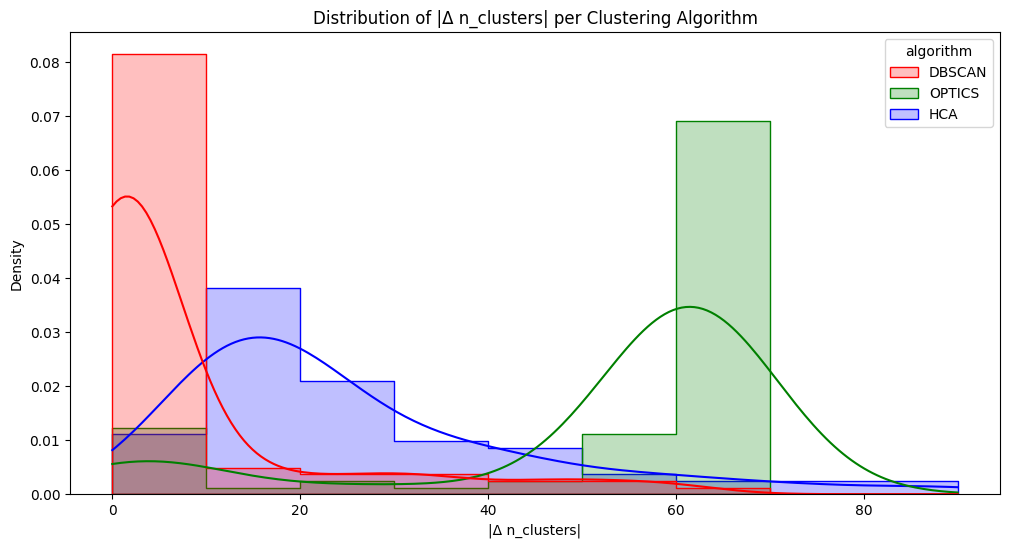

In [3]:
import pandas as pd
import seaborn as sns

# ---------------------------------------
# Build a DataFrame from your stored lists
# ---------------------------------------
df = pd.DataFrame({
    "umap_min_dist": X_plot,
    "hyperparam": Y_plot,
    "delta_clusters": Z_plot,
    "algorithm": C_plot
})

# ---------------------------------------
# Stats table for each algorithm
# ---------------------------------------
stats_table = df.groupby("algorithm")["delta_clusters"].agg(
    ["count", "mean", "median", "std", "min", "max"]
)
print("\n=== Statistics per Algorithm ===\n")
print(stats_table)

# ---------------------------------------
# Seaborn histogram with KDE for Δ clusters
# ---------------------------------------
plt.figure(figsize=(12, 6))
sns.histplot(
    data=df,
    x="delta_clusters",
    hue="algorithm",
    element="step",
    stat="density",
    common_norm=False,
    kde=True,
    palette={"DBSCAN": "r", "OPTICS": "g", "HCA": "b"}
)
plt.title("Distribution of |Δ n_clusters| per Clustering Algorithm")
plt.xlabel("|Δ n_clusters|")
plt.ylabel("Density")
plt.savefig("ClusterFailures_missed_clustering.png")
plt.show()



# **Measuring How Hyperparameters Influence Clustering Errors**

This cell evaluates whether each algorithm’s hyperparameter systematically affects the deviation from the true number of clusters. It groups the experimental results by algorithm and computes both Pearson and Spearman correlations between the algorithm’s hyperparameter and the resulting clustering error.

Pearson captures linear relationships, while Spearman captures monotonic trends, even if non-linear. The resulting table highlights whether higher or lower hyperparameter values tend to increase or reduce misclustering. Strong correlations signal that the algorithm becomes more or less error-prone as parameters change, revealing how sensitive each method is under UMAP-distorted distances.


In [4]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# Build DataFrame from results
df = pd.DataFrame({
    "hyperparam": Y_plot,
    "delta": Z_plot,
    "algorithm": C_plot
})

# Store results
rows = []

for algo in df["algorithm"].unique():
    sub = df[df["algorithm"] == algo]

    pearson_corr, pearson_p = pearsonr(sub["hyperparam"], sub["delta"])
    spearman_corr, spearman_p = spearmanr(sub["hyperparam"], sub["delta"])

    rows.append({
        "algorithm": algo,
        "pearson_corr": pearson_corr,
        "pearson_p": pearson_p,
        "spearman_corr": spearman_corr,
        "spearman_p": spearman_p
    })

corr_df = pd.DataFrame(rows)

print("\n=== Hyperparameter vs Δ Cluster Count Correlation ===")
print(corr_df)



=== Hyperparameter vs Δ Cluster Count Correlation ===
  algorithm  pearson_corr     pearson_p  spearman_corr    spearman_p
0    DBSCAN     -0.475288  7.336978e-06      -0.751524  6.315892e-16
1    OPTICS      0.650120  5.109544e-11       0.502955  1.708376e-06
2       HCA     -0.797632  5.014144e-19      -0.865010  2.247882e-25
